## MFCC Model to predict song features

We will train individual models with MFCC of images as input into CNN model to predict Danceability, instrumentalness, speechiness, Energy, acousticness. There will be individual models for each of these labels to begin with, and we will work towards combining the outputs into one model.

### Import Labels and Data

In [12]:
import os
import requests
import torch

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
csv_file = "/content/drive/MyDrive/tracks_features.csv"
all_tracks = pd.read_csv(csv_file)

In [4]:
def name_of_file(track_id):
  filename = f"/content/drive/MyDrive/tracks_features_audio/{track_id}_audio.mp3"
  return filename

In [7]:
# Iterate through the DataFrame
count = 0
for index, row in all_tracks.iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    if not os.path.exists(filepath):
      print(track_id)
    else:
      count += 1
print(f"finished {count}")

finished 21325


### Load audio and practice converting them to MFCCs

Source: https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html

#### Testing with just waveform 

Ensure we have variety in audio samples being selected

In [16]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

In [45]:
for index, row in all_tracks.head().iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    print(track_id)
    WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
    waveform_mono = torch.mean(WAVEFORM, dim = 0, keepdim=True)
    print(f"Sample rate for {track_id}:", SAMPLE_RATE)
    #plot_waveform(waveform_mono, SAMPLE_RATE)


1xK59OXxi2TAAAbmZK0kBL
Sample rate for 1xK59OXxi2TAAAbmZK0kBL: 44100
4nrPB8O7Y7wsOCJdgXkthe
Sample rate for 4nrPB8O7Y7wsOCJdgXkthe: 44100
3azJifCSqg9fRij2yKIbWz
Sample rate for 3azJifCSqg9fRij2yKIbWz: 44100
78Sw5GDo6AlGwTwanjXbGh
Sample rate for 78Sw5GDo6AlGwTwanjXbGh: 44100
1Y3LN4zO1Edc2EluIoSPJN
Sample rate for 1Y3LN4zO1Edc2EluIoSPJN: 44100


We were originally just visualizing the differnt waveforms, now we're just making sure that all the audio files have the same sample_rate

### Lets create some MFCCs

Brief explanation of what is going on for the following, since I had trouble understanding MFCCs to begin with. Be warned that this explanation was provided by GPT-4 to answer the following prompt: 

"can you explain what these 5 values actually are and what an mfcc transform even does with an audio waveform. I know a waveform is basically plotting what the audio looks like where the amplitudes represent the sounds the human ear hears and the amount of those amplitude changes per second is the sample rate. I guess continue on with this explanation:

n_fft = 2048

win_length = None

hop_length = 1024

n_mels = 256

n_mfcc = 128"

These values are taken directly from the PyTorch tutorial for audio feature extraction

#### GPT-4:

MFCC stands for Mel-Frequency Cepstral Coefficients, and it is a widely-used feature extraction technique for audio signals, especially in speech and music processing. The main idea behind MFCCs is to represent the spectral shape of an audio signal in a compact and informative way that can be used for various tasks such as speech recognition, speaker identification, or music genre classification.

Here's a brief explanation of the values you mentioned:

1. n_fft (Number of FFT points): This value determines the number of points used for the Fast Fourier Transform (FFT). FFT is an algorithm that transforms the audio waveform from the time domain into the frequency domain. It essentially calculates the discrete Fourier transform (DFT) of a sequence, enabling us to analyze the frequency components of the audio signal. In this case, 2048 points are used for the FFT.
2. win_length (Window length): This value determines the size of the window applied to the audio signal before performing the FFT. If not specified (None), it usually defaults to the same value as n_fft. Window functions, such as the Hanning or Hamming window, are applied to mitigate the effect of spectral leakage caused by the finite length of the audio signal.
3. hop_length (Hop length): This value determines the number of samples between successive frames or windows in the audio signal. In this case, 1024 samples separate each frame. Overlapping frames help ensure that we capture the information between windows and provide a smoother representation of the audio signal.
4. n_mels (Number of Mel bands): The Mel scale is a perceptual scale that approximates the human ear's response to different frequencies. After performing the FFT and obtaining the spectrogram, the frequency axis is transformed into the Mel scale using a set of triangular filters. The number of Mel bands (256 in this case) determines the resolution of the Mel-scaled spectrogram, with a higher number of bands providing better frequency resolution.
5. n_mfcc (Number of MFCCs): After obtaining the Mel-scaled spectrogram, the Discrete Cosine Transform (DCT) is applied to the log power of each Mel band. The resulting coefficients are the MFCCs, which are a compact representation of the spectral shape of the audio signal. The number of MFCCs (128 in this case) determines the dimensionality of the feature vector. Generally, the lower-order MFCCs capture the coarse spectral shape, while higher-order MFCCs capture finer spectral details.
In summary, the MFCC transform takes an audio waveform, divides it into overlapping frames, calculates the frequency components using the FFT, and then converts the frequency representation into a more perceptually meaningful representation using the Mel scale. Finally, the MFCCs are calculated by applying the DCT to the log power of the Mel-scaled spectrogram, resulting in a compact representation of the spectral shape of the audio signal.

In [40]:
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [41]:
n_fft = 4096
win_length = None
hop_length = 1024
n_mels = 256
n_mfcc = 20

def plot_mfcc(waveform, sample_rate):
  mfcc_transform = T.MFCC(
      sample_rate=sample_rate,
      n_mfcc=n_mfcc,
      melkwargs={
          "n_fft": n_fft,
          "n_mels": n_mels,
          "hop_length": hop_length,
          "mel_scale": "htk",
      },
  )

  mfcc = mfcc_transform(waveform)
  return plot_spectrogram(mfcc[0])



1xK59OXxi2TAAAbmZK0kBL


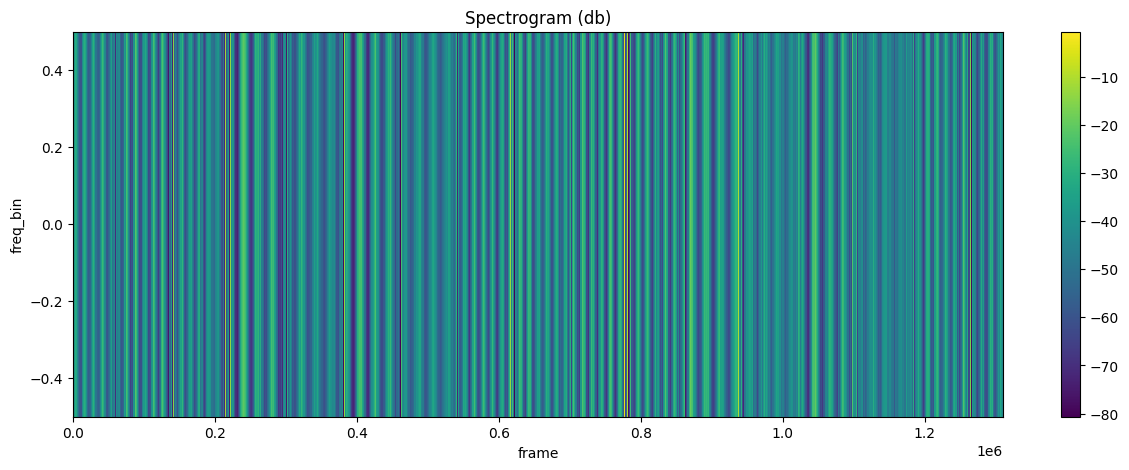

4nrPB8O7Y7wsOCJdgXkthe


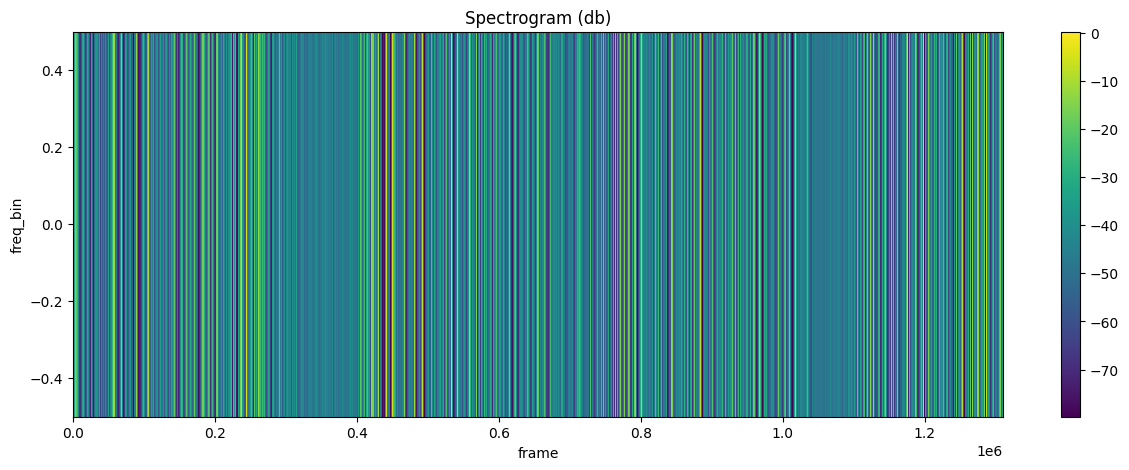

3azJifCSqg9fRij2yKIbWz


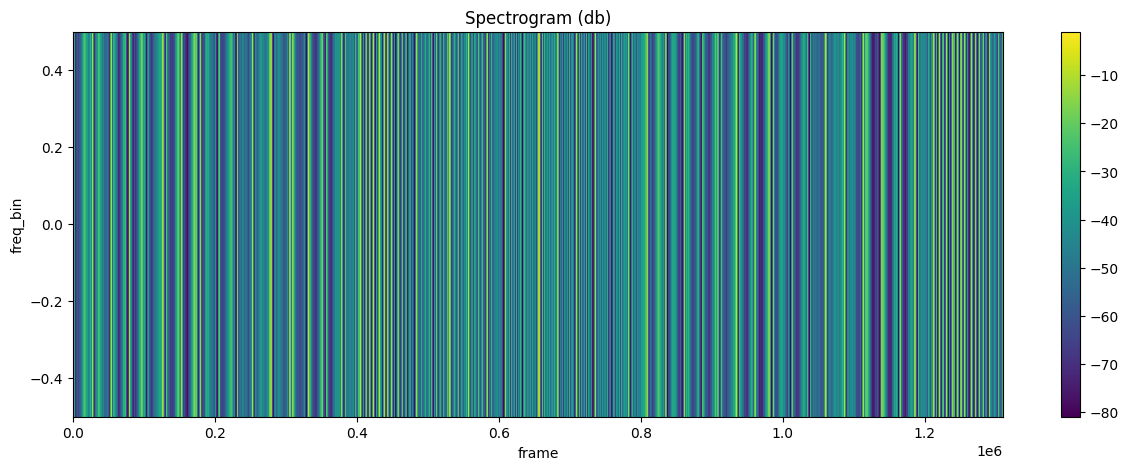

78Sw5GDo6AlGwTwanjXbGh


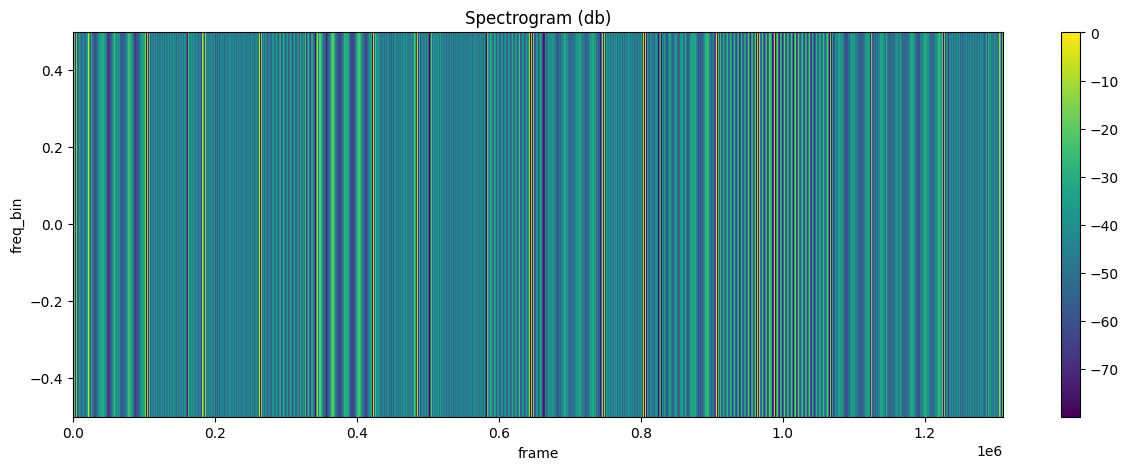

1Y3LN4zO1Edc2EluIoSPJN


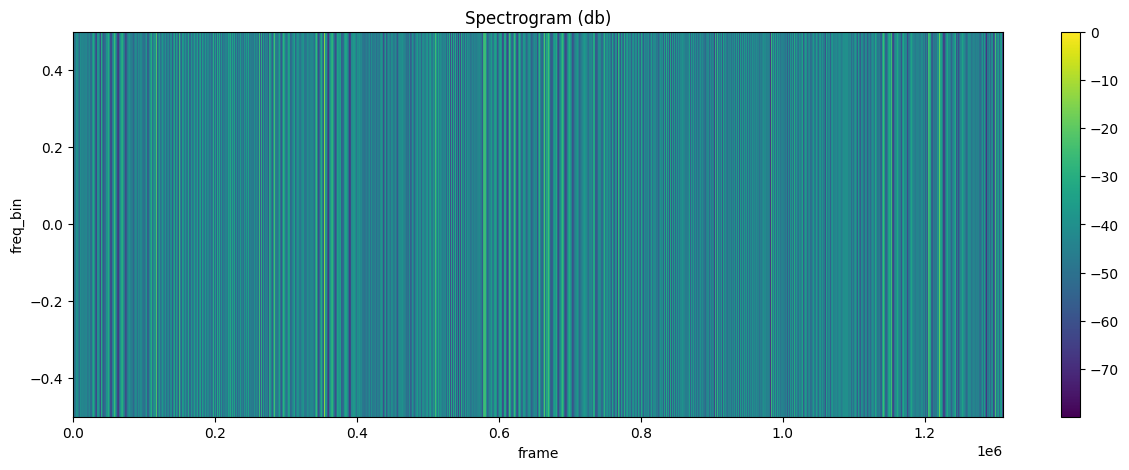

In [43]:
for index, row in all_tracks.head().iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    print(track_id)
    WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
    waveform_mono = torch.mean(WAVEFORM, dim = 0, keepdim=True)
    plot_spectrogram(waveform_mono)


Spectrograms of MFCCs appear a bit compressed, might be benefitial to just view what the MFCC looks like and maybe just feed the information from it directly into a model

1xK59OXxi2TAAAbmZK0kBL


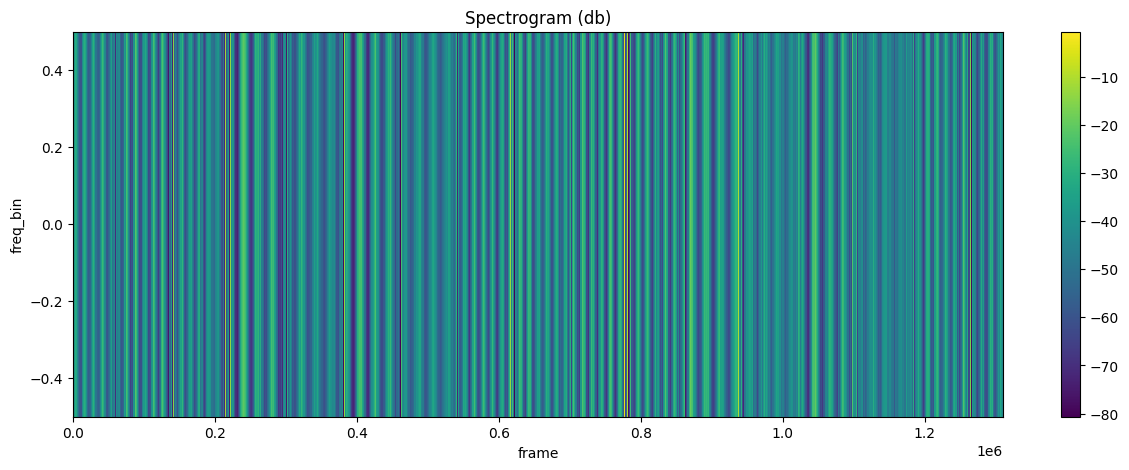

mfcc_transform shape: torch.Size([1, 20, 1280])


In [42]:
row = all_tracks.iloc[0]
track_id = row['id']
filepath = name_of_file(track_id)
print(track_id)
WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
waveform_mono = torch.mean(WAVEFORM, dim = 0, keepdim=True)
plot_spectrogram(waveform_mono)

mfcc_transform = T.MFCC(
      sample_rate=SAMPLE_RATE,
      n_mfcc=n_mfcc,
      melkwargs={
          "n_fft": n_fft,
          "n_mels": n_mels,
          "hop_length": hop_length,
          "mel_scale": "htk",
      },
  )

print("mfcc_transform shape:", mfcc_transform(waveform_mono).shape)


After having experimented with various values for the MFCC parameters, we are settling with the following for each:

n_fft = 4096

win_length = None

hop_length = 1024

n_mels = 256

n_mfcc = 20

Part of our experimentation process will be to change n_mfcc to 40 and change win_length to 1024 such that we have shorter windows to capture more time-varying information at the expense of frequency resolution

Also I'm making the decision to feed the mfcc directly into the model as a 2D tensor. The first argument in the printed shape above represents the batch size. The second arguement is the number of MFCC coefficients. The last arguement represents the number of frames in the MFCC representation of the image. Given our hop_length of 1024, clip length of 30 seconds that are sampled at 44100 Hz, we are looking at about (30 * 44100)/1024 frames. The edge effects of windowing and padding possibly contributes to this number being slightly lower than the actual value. 